# <div style="text-align: center; color: cyan">Plot and TensorBoard</div>

## <div style="text-align: center; color: lime">Setup</div>

In [28]:
import os

os.environ["KERAS_BACKEND"] = "torch"

## <div style="text-align: center; color: lime">Imports</div>

In [40]:
from pathlib import Path

from matplotlib import pyplot as plt

import torch
from torch.utils.data import random_split, DataLoader

from torchvision.datasets import ImageFolder
from torchvision import transforms

import keras
from keras import layers
from keras.applications import MobileNetV2

import kagglehub

import datetime

## <div style="text-align: center; color: lime">Load the data</div>

In [30]:
path = kagglehub.dataset_download("balabaskar/tom-and-jerry-image-classification")

data_path = Path(path) / "tom_and_jerry/tom_and_jerry"

trs = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

all_data = ImageFolder(data_path, transform=trs)

g1 = torch.Generator().manual_seed(20)
train_data, val_data, test_data = random_split(all_data, [0.7, 0.2, 0.1], g1)

train_loader = DataLoader(train_data, batch_size=12, shuffle=True)
val_loader = DataLoader(val_data, batch_size=12, shuffle=False)
test_loader = DataLoader(test_data, batch_size=12, shuffle=False)


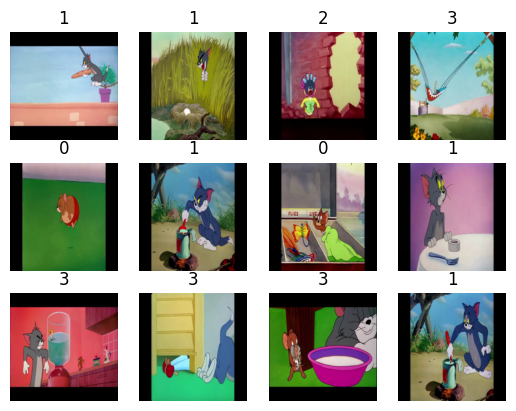

In [31]:
fig, axes = plt.subplots(3, 4)

axes_ravel = axes.ravel()

for images, labels in train_loader:
    for i, (image, label) in enumerate(zip(images, labels)):
        axes_ravel[i].imshow(transforms.ToPILImage()(image))
        axes_ravel[i].set_axis_off()
        axes_ravel[i].set_title(f"{label}")
    break

## <div style="text-align: center; color: lime">Transfer Learning</div>

In [32]:
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

model = keras.Sequential(
    [
        layers.Input(shape=(3, 224, 224)),
        layers.Permute((2, 3, 1)),
        base_model,
        layers.Flatten(),
        layers.Dense(4, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ permute_1 (Permute)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │       250,884 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,508,868 (9.57 MB)

 Trainable params: 250,884 (980.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [33]:
history = model.fit(train_loader, epochs=5, validation_data=val_loader)

Epoch 1/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 36s 113ms/step - accuracy: 0.4587 - loss: 8.2498 - val_accuracy: 0.5091 - val_loss: 7.6660
Epoch 2/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 44s 137ms/step - accuracy: 0.5288 - loss: 7.4120 - val_accuracy: 0.5119 - val_loss: 7.7352
Epoch 3/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 44s 138ms/step - accuracy: 0.5450 - loss: 7.1780 - val_accuracy: 0.5064 - val_loss: 7.7198
Epoch 4/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.5510 - loss: 7.1044 - val_accuracy: 0.5091 - val_loss: 7.7796
Epoch 5/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 40s 125ms/step - accuracy: 0.5593 - loss: 7.0033 - val_accuracy: 0.5383 - val_loss: 7.2549


In [34]:
loss, accuracy = model.evaluate(test_loader)

print("loss:", loss)
print("accuracy:", accuracy)

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.6161 - loss: 6.0595
loss: 6.059478282928467
accuracy: 0.6160877346992493


## <div style="text-align: center; color: lime">Plot</div>

In [35]:
print(history.history)

{'accuracy': [0.45867013931274414, 0.5288135409355164, 0.5449804663658142, 0.5509778261184692, 0.5593220591545105], 'loss': [8.249772071838379, 7.41204833984375, 7.177958011627197, 7.104381561279297, 7.00330924987793], 'val_accuracy': [0.5091241002082825, 0.5118613243103027, 0.5063868761062622, 0.5091241002082825, 0.5383211970329285], 'val_loss': [7.666019916534424, 7.735220432281494, 7.719765663146973, 7.779564380645752, 7.254864692687988]}


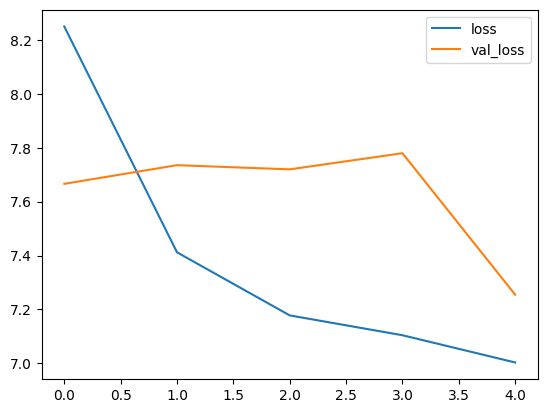

In [38]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])

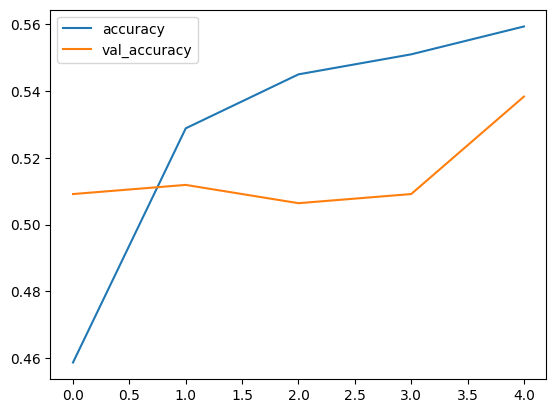

In [39]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])

## <div style="text-align: center; color: lime">TensorBoard</div>

In [41]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [42]:
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

model = keras.Sequential(
    [
        layers.Input(shape=(3, 224, 224)),
        layers.Permute((2, 3, 1)),
        base_model,
        layers.Flatten(),
        layers.Dense(4, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


In [44]:
history = model.fit(
    train_loader,
    epochs=5,
    validation_data=val_loader,
    callbacks=[tensorboard_callback],
)


Epoch 1/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 53s 166ms/step - accuracy: 0.5849 - loss: 5.2125 - val_accuracy: 0.6870 - val_loss: 4.1534
Epoch 2/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 39s 123ms/step - accuracy: 0.7374 - loss: 3.5621 - val_accuracy: 0.7518 - val_loss: 3.4699
Epoch 3/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 40s 124ms/step - accuracy: 0.7562 - loss: 3.4342 - val_accuracy: 0.7619 - val_loss: 3.3754
Epoch 4/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 39s 121ms/step - accuracy: 0.7883 - loss: 3.0567 - val_accuracy: 0.7372 - val_loss: 3.6708
Epoch 5/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 39s 121ms/step - accuracy: 0.8068 - loss: 2.7830 - val_accuracy: 0.7564 - val_loss: 3.6201


In [2]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<p style="text-align: center; font-family: "Trebuchet MS", sans-serif; color: #888; font-size: 0.9em; margin-top: 2em; border-top: 1px solid #ccc; padding-top: 0.5em;">
    @LiterallyTheOne — PhD Candidate in Artificial Intelligence
</p>

<div style="text-align: center">
<a style="margin: 1em" href="https://literallytheone.github.io">https://literallytheone.github.io</a>
</div>
